#### Merge 2 sets of Metrics and Store information to 1 data set

###### Metrics Set 01 --  From RGM
- 01 OSCA (7 Stores without OSCA records)
- 02 Sales volumn (2 Stores without sales records)
- 03 SKU vs Book (7 Stores without SKU vs Book records)
- 04 CFF (197 Stores without CFF records)

###### Metrics Set 02 --  From AP Dashboard
- 05 Shrink TY & LY

###### Store Information Set 01 --  From AP Dashboard
- 01 Inventory Date

###### Store Information Set 01 --  Remodel 
- 02 Whether stores are remodeled during Aug. and Nov.

###### Store Information Set 03 --  From Teradata: ww_core_dim_vm.store_dim
- 03 BANNER_DESC 
- 04 REGION_NBR
- 05 CITY_NAME
- 06 STATE_PROV_CODE
- 07 SUBDIV_NAME
- 08 REGION_NAME
- 09 MARKET_AREA_NBR
- 10 LATITUDE_DGR
- 11 LONGITUDE_DGR
- 12 OPEN_DATE

- ? No Division 1s: where to source the data?
- ? Indicator that can identify whether the store has fuel


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [2]:
## Set the directory where you store the data
## Ensure the files you are going to use are in the same folder
os.chdir(r'C:\Users\t0d00dh\01_Projects\Combine Assurance\2nd_Round_Sampling')

In [3]:
## Import the updated data
## Change the names in the quotation marks if the file names are changed

# till 11/30/2018,the latest RGM report only has Sep 2018 data
metrics_RGM = pd.read_csv('RGM_092018.csv')


# FY 19 Shrink data updated date: 11/21/2018
######### Copy the Detail sheet to a new xlsx file, not xlsb file
metrics_AP_2019  = pd.ExcelFile('FY19 Shrink Results Summary.xlsx').parse('Detail') 

# FY 18 Shrink data updated date: 02/12/2018
metrics_AP_2018  = pd.ExcelFile('FY18 Shrink Results Summary.xlsx').parse('Detail') 

# From Teradata
store_loc    = pd.ExcelFile('Store_Loc.xlsx').parse('Sheet1') 

# From Teradata
store_close  = pd.ExcelFile('Store_closed Date.xlsx').parse('Sheet1') 

# Provided by Ops
fuel_store = pd.ExcelFile('Store_Gas_Station_Operation.xlsx').parse('Projects')

# Provided by Ops
remodel = pd.read_csv('Remodel_07202018.csv')



###### Consolidated Metrics contains largest amount of stores, use Consolidated Metrics as the base data to shape the new data

In [4]:
# in RGM report, SHRINKYTD represents SKU vs Book
selected_metrics = ['SALESYTD','SHRINKYTD','OSCAYTD','CFFYTD']
selected_RGM = metrics_RGM[metrics_RGM['metric'].isin(selected_metrics)]

In [5]:
selected_RGM  = selected_RGM .rename(columns={'﻿store': 'store'})

In [7]:
# Reshape data using metrics values
df_1 = pd.pivot_table(selected_RGM,index = ['store'],values = ['metric_value'],columns = 'metric')
df_1 = df_1.reset_index()
df_1.columns = ['STORE_NBR','CFF_Value','OSCA_Value','Sales_Volume','SkuBook_Value']


# Reshape data using metrics rank
df_2 = pd.pivot_table(selected_RGM,index = ['store'],values = ['metric_rank'],
                      columns = 'metric')
df_2 = df_2.reset_index()
df_2.columns = ['STORE_NBR','CFF_Rank_RGM','OSCA_Rank_RGM','Sales_Rank_RGM','SkuBook_Rank_RGM']

# Reshape data using metric_pct_of_goal
df_3 = pd.pivot_table(selected_RGM,index = ['store'],values = ['metric_pct_of_goal'],
                      columns = 'metric')
df_3 = df_3.reset_index()
df_3.columns = ['STORE_NBR','CFF_pct2Plan','OSCA_pct2Plan','Sales_pct2Plan','SkuBook_pct2Plan']


# merge the 3 subset of RGM metrics
RGM_metrics = pd.merge(pd.merge(df_1,df_2),df_3)

In [8]:
# fill null cff value
fil_w_con_bool = (RGM_metrics['CFF_Value'].isnull()) & RGM_metrics['STORE_NBR'].isin(metrics_Con[metrics_Con['CFF COMBINED'].notnull()]['STORE'])
con_fil_bool = metrics_Con['STORE'].isin(RGM_metrics[fil_w_con_bool]['STORE_NBR'])


ix_fil_w_con = RGM_metrics[fil_w_con_bool].index
ix_fill      = metrics_Con[con_fil_bool].sort_values(by=['STORE']).index



for i in range(len(ix_fil_w_con)):
    RGM_metrics.loc[ix_fil_w_con[i],'CFF_Value'] = metrics_Con.loc[ix_fill[i],'CFF COMBINED INDEX']*100
   

NameError: name 'metrics_Con' is not defined

In [9]:
# check how does RGM ranks the stores
RGM_meth = pd.DataFrame()
rank_type = [col for col in RGM_metrics.columns if 'Rank' in col]
for i in range(len(rank_type)):
    rank = pd.pivot_table(RGM_metrics,index = rank_type[i],
                          values = [RGM_metrics.columns[RGM_metrics.columns.get_loc(rank_type[i])+4]],
                          aggfunc={'count',np.min,np.max})
    rank = rank.reset_index()
    rank.columns = [rank_type[i],'Count','Min','Max']
    rank['Interval'] = rank['Max'] - rank['Min']
    rank.to_csv('RGM_meth.csv', mode='a', header=True,index = False)


###### Add Store Information

In [10]:
store_info = pd.merge(store_loc[['STORE_NBR','OPEN_DATE','BANNER_DESC','CITY_NAME','STATE_PROV_CODE',
                        'SUBDIV_NAME','REGION_NAME','MARKET_AREA_NBR','LATITUDE_DGR','LONGITUDE_DGR']],
                      store_close[['STORE_NBR','CLOSE_DATE']])

store_info['OPEN_DATE'] = store_info['OPEN_DATE'].apply(pd.to_datetime)
store_info['New_Store'] = 'N' 
new_index = store_info[[store_info['OPEN_DATE'][i].year == 2018 
                        or store_info['OPEN_DATE'][i].year == 2017 
                        for i in range(len(store_info))]].index
store_info.loc[new_index,'New_Store'] = 'Y'

store_info['Close_Store'] = 'N' 
store_info.loc[store_info[store_info['CLOSE_DATE'] != '0001-01-01'].index,'Close_Store'] = 'Y'

RGM_Loc = pd.merge(RGM_metrics,store_info,how = 'left')

In [11]:
RGM_Loc['Fuel'] = 'N'

RGM_Loc.loc[RGM_Loc[RGM_Loc['STORE_NBR'].isin(fuel_store['Store#'])].index,'Fuel'] = 'Y'

###### Merge Remodel Data

In [12]:
# Remodel from August to November
# pd.to_datetime(remodel['Construction Start'][0]).year
remodel['Construction Start'] = remodel['Construction Start'].apply(pd.to_datetime)
remodel['Construction Complete'] = remodel['Construction Complete'].apply(pd.to_datetime)


start = remodel[[remodel['Construction Start'][i].year ==2018 
                       and remodel['Construction Start'][i].month>=8 
                       and remodel['Construction Start'][i].month<= 11
                       for i in range(len(remodel))]]['Store Number']

complete = remodel[[remodel['Construction Complete'][i].year ==2018 
                       and remodel['Construction Complete'][i].month>=8 
                       and remodel['Construction Complete'][i].month<= 11
                       for i in range(len(remodel))]]['Store Number']

remodel_store = np.unique(list(start) + list(complete))

RGM_Loc['remodel'] = 'N'
RGM_Loc.loc[RGM_Loc[RGM_Loc['STORE_NBR'].isin(remodel_store)].index,'remodel'] = 'Y'

###### Merge AP Dashboard Data

In [13]:
TY_index = metrics_AP_2019[metrics_AP_2019['TY Shrink'].notnull()].index
LY_index = metrics_AP_2019[metrics_AP_2019['TY Shrink'].isnull() & metrics_AP_2019['LY Shrink'].notnull()].index
No_index = set(metrics_AP_2019.index) - set(TY_index) - set(LY_index)


metrics_AP_2019.loc[TY_index,'Shrink'] = metrics_AP_2019.loc[TY_index,'TY Shrink']
metrics_AP_2019.loc[LY_index,'Shrink'] = metrics_AP_2019.loc[LY_index,'LY Shrink']


metrics_AP_2019.loc[No_index,'Shrink'] = np.nan

metrics_AP_2019.loc[TY_index,'Ret %'] = metrics_AP_2019.loc[TY_index,'Ret % (TY)']
metrics_AP_2019.loc[LY_index,'Ret %'] = metrics_AP_2019.loc[LY_index,'Ret % (LY)']
metrics_AP_2019.loc[No_index,'Ret %'] = np.nan

metrics_AP_2019.loc[TY_index,'TY_LY'] = 'TY'
metrics_AP_2019.loc[LY_index,'TY_LY'] = 'LY'
metrics_AP_2019.loc[No_index,'TY_LY'] = np.nan


RGM_AP_Loc = pd.merge(RGM_Loc, metrics_AP_2019[['STORE_NBR','Type','Inv Date','Shrink','Ret %','TY_LY']],
                  how='left')



In [14]:
# If the store has no shrink record in 2019 report, use its 2018 record
bool_RGM  = (RGM_AP_Loc['Shrink'].isnull())& (RGM_AP_Loc['STORE_NBR'].isin(metrics_AP_2018['Store']))
bool_2018 = metrics_AP_2018['Store'].isin(RGM_AP_Loc[RGM_AP_Loc['Shrink'].isnull()]['STORE_NBR'])

ix_2018  = metrics_AP_2018[bool_2018]['Store'].index
ix_RGM  = RGM_AP_Loc[bool_RGM]['STORE_NBR'].index

for i in range(len(ix_2018)):
    RGM_AP_Loc.loc[ix_RGM[i],'Shrink'] = metrics_AP_2018.loc[ix_2018[i],'TY Shrink']
    RGM_AP_Loc.loc[ix_RGM[i],'Ret %']  = metrics_AP_2018.loc[ix_2018[i],'Ret % (TY)']
    RGM_AP_Loc.loc[ix_RGM[i],'TY_LY']  = 'LY'
    RGM_AP_Loc.loc[ix_RGM[i],'Inv Date']  = metrics_AP_2018.loc[ix_2018[i],'Inv Date']


In [15]:
from datetime import datetime
Inv_window = datetime.today()-RGM_AP_Loc['Inv Date']
Inv_window = Inv_window.dt.days
RGM_AP_Loc['Inv_window'] = Inv_window

In [16]:
RGM_AP_Loc['In_Inv_window'] = np.nan

RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc['Inv_window']>30].index,'In_Inv_window'] ='N'
RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc['Inv_window']<-14].index,'In_Inv_window'] ='N'
RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc['In_Inv_window'].isnull()].index,'In_Inv_window']= 'Y'

In [ ]:
######  Assign 'SUBDIV_NAME' code to stores if the store belongs to 'NEIGHBORHOOD MARKET'

In [17]:
RGM_AP_Loc['SUBDIV'] = RGM_AP_Loc['SUBDIV_NAME']

print(np.unique(RGM_AP_Loc['SUBDIV_NAME']))

label_pivt = pd.DataFrame((zip(RGM_AP_Loc['STATE_PROV_CODE'], RGM_AP_Loc['SUBDIV_NAME']))).drop_duplicates()
label_pivt.columns = ['STATE_PROV_CODE','SUBDIV_NAME']
label_pivt = pd.pivot_table(label_pivt,index = ['STATE_PROV_CODE'],
                         values = ['SUBDIV_NAME'],
                         aggfunc = {'SUBDIV_NAME': 'count'})
label_pivt = label_pivt.reset_index()

#------------------------------------------------------------------------------
# check which state has 2 subdiv_name
#------------------------------------------------------------------------------
checking_2 = pd.pivot_table(RGM_AP_Loc,index = ['STATE_PROV_CODE','SUBDIV_NAME'],
                         values = ['STORE_NBR'],
                         aggfunc = {'STORE_NBR': 'count'})
checking_2 = checking_2.reset_index()

label_pivt_2 = label_pivt[label_pivt['SUBDIV_NAME']==2]


for i in range(len(label_pivt_2['STATE_PROV_CODE'])):
    
    state = list(label_pivt_2['STATE_PROV_CODE'])[i]    
    
    bool_1 = (RGM_AP_Loc['STATE_PROV_CODE'] == state) & (RGM_AP_Loc['SUBDIV_NAME'] == 'NEIGHBORHOOD MARKET')
    bool_2 = (RGM_AP_Loc['STATE_PROV_CODE'] == state) & (RGM_AP_Loc['SUBDIV_NAME'] != 'NEIGHBORHOOD MARKET')
    
    RGM_AP_Loc.iloc[RGM_AP_Loc[bool_1].index,-1] = np.unique(RGM_AP_Loc.iloc[RGM_AP_Loc[bool_2].index,-1])[0]

#------------------------------------------------------------------------------
#check which has 3 subdiv_name
#------------------------------------------------------------------------------

# which state was classified to 3 subdivisions
label_pivt_3 = label_pivt[label_pivt['SUBDIV_NAME']==3] 

# in above listed states, which city was classified to 2 subdivisions
df_sub = RGM_AP_Loc[RGM_AP_Loc['STATE_PROV_CODE'].isin(label_pivt_3['STATE_PROV_CODE'])]
checking_3_1= pd.DataFrame((zip(df_sub['STATE_PROV_CODE'], df_sub['SUBDIV_NAME'],df_sub['CITY_NAME']))).drop_duplicates()
checking_3_1.columns = ['STATE_PROV_CODE','SUBDIV_NAME','CITY_NAME']
checking_3_1 = pd.pivot_table(checking_3_1,index = ['STATE_PROV_CODE','CITY_NAME'],
                         values = ['SUBDIV_NAME'],
                         aggfunc = {'SUBDIV_NAME': 'count'})
checking_3_1 = checking_3_1.reset_index()
checking_3_1 = checking_3_1[checking_3_1['SUBDIV_NAME']==2]


for i in range(len(checking_3_1['CITY_NAME'])):
    city  = list(checking_3_1['CITY_NAME'])[i]
    state = list(checking_3_1[checking_3_1['CITY_NAME'] == city]['STATE_PROV_CODE'])[0]
    
    bool_1 = (RGM_AP_Loc['CITY_NAME'] == city ) & (RGM_AP_Loc['STATE_PROV_CODE'] == state) & (RGM_AP_Loc['SUBDIV_NAME'] == 'NEIGHBORHOOD MARKET')
    bool_2 = (RGM_AP_Loc['CITY_NAME'] == city ) & (RGM_AP_Loc['STATE_PROV_CODE'] == state) & (RGM_AP_Loc['SUBDIV_NAME'] != 'NEIGHBORHOOD MARKET')

    RGM_AP_Loc.iloc[RGM_AP_Loc[bool_1].index,-1] = np.unique(RGM_AP_Loc.iloc[RGM_AP_Loc[bool_2].index,-1])[0]

    
#------------------------------------------------------------------------------
# After tying back the subdivision names using state names and city name 
# there are still 28 stores have 'NEIGHBORHOOD MARKET' as their subdivisions
# assign the major subdivision name of the state to these 28 stores
#------------------------------------------------------------------------------    


[u'CENTRAL' u'NEIGHBORHOOD MARKET' u'NORTHEAST' u'SOUTHEAST' u'WEST']


In [18]:
checking_4 = checking_2[checking_2['SUBDIV_NAME']!='NEIGHBORHOOD MARKET']
for i in np.unique(RGM_AP_Loc[RGM_AP_Loc['SUBDIV'] =='NEIGHBORHOOD MARKET']['STATE_PROV_CODE']):
    bool_1 = (RGM_AP_Loc['SUBDIV'] =='NEIGHBORHOOD MARKET') & (RGM_AP_Loc['STATE_PROV_CODE'] == i)
    ix = RGM_AP_Loc[bool_1].index
    
    comp = checking_4[checking_4 ['STATE_PROV_CODE']== i]['STORE_NBR']
    if list(comp)[0]>list(comp)[1]:
        subdivision = checking_4.loc[comp.index[0],'SUBDIV_NAME']
    else: subdivision = checking_4.loc[comp.index[1],'SUBDIV_NAME']
    
    
    RGM_AP_Loc.loc[ix,'SUBDIV'] = subdivision

In [19]:
RGM_AP_Loc['Format'] ='Division_1'
large_format_bool = (RGM_AP_Loc['BANNER_DESC'] == 'WM Supercenter')|(RGM_AP_Loc['BANNER_DESC'] == 'Wal-mart EF Plus')
RGM_AP_Loc.loc[RGM_AP_Loc[large_format_bool].index,'Format'] = 'Large Format'
NHN_bool = RGM_AP_Loc['BANNER_DESC']=='WM Neighborhood Market - SUPERMARKET'
RGM_AP_Loc.loc[RGM_AP_Loc[NHN_bool].index,'Format'] = 'NHM Format'


###### Ranking Stores across U.S - Scale: 1 - 20
- Sales (not Sales to Index, but just Sales Volume) – 25
- Shrink – 25
- OSCA – 25
- SKU vs Book – 15
- CFF – 10

###### Scale of each metric is 1-20
- Sales Volume --- 25%
- Shrink --------- 25%
- OSCA ----------- 25%
- SKU vs Book ---- 15%
- CFF ------------ 10%



In [20]:
check_list =rank_type+['Ret %','Sales_Volume']

In [21]:
# check which metric contains null value
for i in check_list:
    print(i,sum((RGM_AP_Loc[i].isnull())))

('CFF_Rank_RGM', 108)
('OSCA_Rank_RGM', 10)
('Sales_Rank_RGM', 2)
('SkuBook_Rank_RGM', 6)
('Ret %', 11)
('Sales_Volume', 2)


In [22]:
# Create Columns to indicate which metrics the store does not have
rank_value = ['CFF_pct2Plan','Sales_Volume','Ret %','OSCA_pct2Plan','SkuBook_pct2Plan']

for i in rank_value:
    RGM_AP_Loc['_'.join(['Lack',i])] = 'N'
    RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc[i].isnull()].index,'_'.join(['Lack',i])] = 'Y'
  

In [23]:
def rank_function(metrics):
    df_sub = RGM_AP_Loc[RGM_AP_Loc[metrics].notnull()]
    j = -5
    for i in range(20):
        j += 5
        p = j+5
        
        lower_bound = np.percentile(abs(df_sub[metrics]),j)
        upper_bound = np.percentile(abs(df_sub[metrics]),p)
        rank_bool   = (abs(df_sub[metrics])>=lower_bound)&(abs(df_sub[metrics])<= upper_bound)
        
        RGM_AP_Loc.loc[df_sub[rank_bool].index,'_'.join([metrics,'Rank','US'])] = i+1
     
    # if the value is null, rank the store to 1    
    RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc[metrics].isnull()].index,'_'.join([metrics,'Rank','US'])] = 1

for i in rank_value:
    rank_function(i)

# consolidated rank
W_Sales  = 0.25 *RGM_AP_Loc['Sales_Volume_Rank_US']
W_Shrink = 0.25 *RGM_AP_Loc['Ret %_Rank_US']
W_OSCA   = 0.25 *RGM_AP_Loc['OSCA_pct2Plan_Rank_US']
W_CFF    = 0.10 *RGM_AP_Loc['CFF_pct2Plan_Rank_US']
W_SkuBook   = 0.15 *RGM_AP_Loc['SkuBook_pct2Plan_Rank_US']
RGM_AP_Loc['Consol_Rank_US'] = W_Sales + W_Shrink + W_OSCA + W_CFF + W_SkuBook 

                           

In [24]:
def rank_function_1(RankType,scale,metrics):
    distict_type = np.unique(RGM_AP_Loc[RankType])
    for k in distict_type:
        df_sub = RGM_AP_Loc[RGM_AP_Loc[RankType] == k]
        df_sub = df_sub[df_sub[metrics].notnull()]
        j = -100/scale
        for i in range(scale):
            j += 100/scale
            p = j + 100/scale
            
            lower_bound = np.percentile(abs(df_sub[metrics]),j)
            upper_bound = np.percentile(abs(df_sub[metrics]),p)
            rank_bool   = (abs(df_sub[metrics])>=lower_bound)&(abs(df_sub[metrics])<= upper_bound)
            RGM_AP_Loc.loc[df_sub[rank_bool].index,'_'.join([metrics,'Rank',RankType])] = i+1
        
        # if the value is null, rank the store to 1
        RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc[metrics].isnull()].index,'_'.join([metrics,'Rank',RankType])] = 1

        
# reverse ranking method for ret and skubook        
def rank_function_2(RankType,scale,metrics):
    distict_type = np.unique(RGM_AP_Loc[RankType])
    for k in distict_type:
        df_sub = RGM_AP_Loc[RGM_AP_Loc[RankType] == k]
        df_sub = df_sub[df_sub[metrics].notnull()]
        j = -100/scale
        for i in range(scale)[::-1]:
            j += 100/scale
            p = j + 100/scale
            
            lower_bound = np.percentile(abs(df_sub[metrics]),j)
            upper_bound = np.percentile(abs(df_sub[metrics]),p)
            rank_bool   = (abs(df_sub[metrics])>=lower_bound)&(abs(df_sub[metrics])<= upper_bound)
            RGM_AP_Loc.loc[df_sub[rank_bool].index,'_'.join([metrics,'Rank',RankType])] = i+1
        
        # if the value is null, rank the store to 1
        RGM_AP_Loc.loc[RGM_AP_Loc[RGM_AP_Loc[metrics].isnull()].index,'_'.join([metrics,'Rank',RankType])] = 1
        
        
['CFF_pct2Plan','Sales_Volume','Ret %','OSCA_pct2Plan','SkuBook_pct2Plan']        
        
        
for i in ['CFF_pct2Plan','Sales_Volume','OSCA_pct2Plan']:
    rank_function_1('Format',20,i)

for i in ['Ret %','SkuBook_pct2Plan']:
    rank_function_2('Format',20,i)
    
# consolidated rank
W_Sales  = 0.25 *RGM_AP_Loc['Sales_Volume_Rank_Format']
W_Shrink = 0.25 *RGM_AP_Loc['Ret %_Rank_Format']
W_OSCA   = 0.25 *RGM_AP_Loc['OSCA_pct2Plan_Rank_Format']
W_CFF    = 0.10 *RGM_AP_Loc['CFF_pct2Plan_Rank_Format']
W_SkuBook   = 0.15 *RGM_AP_Loc['SkuBook_pct2Plan_Rank_Format']
RGM_AP_Loc['Consol_Rank_Format'] = W_Sales + W_Shrink + W_OSCA + W_CFF + W_SkuBook 
    
'''
for i in rank_value:
    rank_function_1('REGION_NAME',5,i)
'''


"\nfor i in rank_value:\n    rank_function_1('REGION_NAME',5,i)\n"

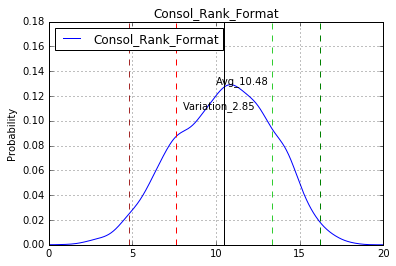

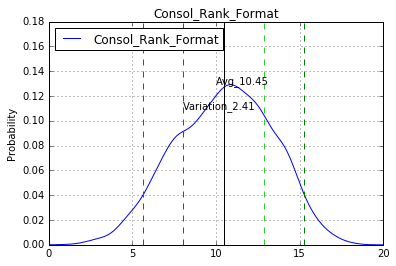

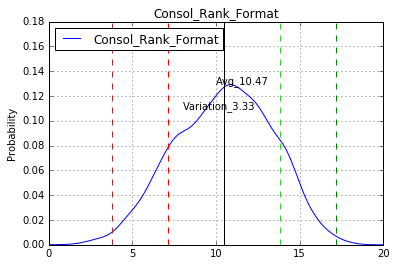

In [25]:
# Create Bucket Function
def bucket(total_rank,df):
    avg = np.mean(df[total_rank])
    std = np.std(df[total_rank])
    
    df_ix = df.index
    high_ix = RGM_AP_Loc[RGM_AP_Loc[total_rank] <= avg-2*std].index
    high_ix = [i for i in high_ix if i in df_ix]
    
    medium_h_ix = RGM_AP_Loc[RGM_AP_Loc[total_rank] <= avg-std].index
    medium_h_ix = [i for i in medium_h_ix if i in df_ix]
    
    
    medium_ix = RGM_AP_Loc[RGM_AP_Loc[total_rank] <= avg+std].index
    medium_ix = [i for i in medium_ix if i in df_ix]
    
    
    medium_low_ix = RGM_AP_Loc[RGM_AP_Loc[total_rank] <= avg+2*std].index
    medium_low_ix = [i for i in medium_low_ix if i in df_ix]
    
    low_ix = RGM_AP_Loc[RGM_AP_Loc[total_rank] <= max(df[total_rank])].index
    low_ix = [i for i in low_ix if i in df_ix]
    
    
    low_ix = set(low_ix) - set(medium_low_ix)
    medium_low_ix = set(medium_low_ix) - set(medium_ix)
    medium_ix  = set(medium_ix) - set(medium_h_ix)
    medium_h_ix = set(medium_h_ix) - set(high_ix)
    
    #print(len(df_ix))
    #print(len(high_ix)+len(medium_h_ix)+len(medium_ix)+len(medium_low_ix)+len(low_ix))
    
    bk_name = '_'.join(['Bucket',total_rank.split('_')[-1]])
    RGM_AP_Loc.loc[low_ix,bk_name ] ='Top'
    RGM_AP_Loc.loc[medium_low_ix,bk_name ] ='Medium Top'
    RGM_AP_Loc.loc[medium_ix ,bk_name] ='Medium'
    RGM_AP_Loc.loc[medium_h_ix ,bk_name ] ='Medium Bottom'
    RGM_AP_Loc.loc[high_ix,bk_name] ='Bottom' 
    
    pd.DataFrame(RGM_AP_Loc[total_rank]).plot(kind='density')
    #plt.xlabel('_'.join([bk_name,df['Format'][0]]))
    plt.ylabel('Probability')
    plt.title(total_rank)
    #
    
    plt.axis([0, 20, 0, 0.18])
    plt.grid(True)


    plt.axvline(x=avg,color='k', linestyle='-')
    plt.axvline(x=avg-2*std,color='brown', linestyle='--')
    plt.axvline(x=avg-std,color='r', linestyle='--')
    plt.axvline(x=avg+std,color='limegreen', linestyle='--')
    plt.axvline(x=avg+2*std,color='green', linestyle='--')
    
    plt.text(10, .13, '_'.join(['Avg',str(round(avg,2))]))
    plt.text(8, .11, '_'.join(['Variation',str(round(std,2))]))
    plt.show()
    

    
df_list = [RGM_AP_Loc[RGM_AP_Loc['Format']==i] for i in RGM_AP_Loc['Format'].unique()]


#bucket('Consol_Rank_US',RGM_AP_Loc)
bucket('Consol_Rank_Format',df_list[0])
bucket('Consol_Rank_Format',df_list[1])
bucket('Consol_Rank_Format',df_list[2])   



###### Ranking Stores across Subdivsions - Scale: 1 - 10
###### Ranking Stores across Regions - Scale: 1 - 5

In [26]:
RGM_AP_Loc.to_excel('CombineAssurance_US.xlsx', sheet_name='sheet1', index=False)

###### Change data to long format for visualization

In [ ]:
def wide2long(rank_set):
    df_melt = pd.melt(RGM_AP_Loc, id_vars=['STORE_NBR'], value_vars=rank_set).sort_values(by=['STORE_NBR'])
    df_long = pd.merge(df_melt,RGM_AP_Loc[['STORE_NBR']+scores+rank_value+store_info],how = 'left')
    return df_long

rank_value = ['CFF_pct2Plan','Sales_Volume','Ret %','Shrink','OSCA_pct2Plan','SkuBook_pct2Plan']
scores = [col for col in RGM_AP_Loc.columns if 'Consol' in col]

store_info = ['OPEN_DATE','BANNER_DESC','Format','CITY_NAME',
              'STATE_PROV_CODE','SUBDIV_NAME','SUBDIV','REGION_NAME',
              'MARKET_AREA_NBR','LATITUDE_DGR','LONGITUDE_DGR',
              'New_Store','Close_Store','Fuel','remodel','Inv Date',
              'Inv_window','In_Inv_window',
              'Lack_Ret %','TY_LY','Lack_CFF_pct2Plan','Lack_Sales_Volume',
              'Lack_OSCA_pct2Plan','Lack_SkuBook_pct2Plan','Bucket_Format']

#rank_us = list(set([col for col in RGM_AP_Loc.columns if col.endswith('_Rank')])- set(scores))
#rank_subdiv = list(set([col for col in RGM_AP_Loc.columns if col.endswith('_Rank_SUBDIV')])- set(scores))
#rank_region = list(set([col for col in RGM_AP_Loc.columns if col.endswith('_Rank_REGION_NAME')])- set(scores))

rank_format = list(set([col for col in RGM_AP_Loc.columns if col.endswith('_Rank_Format')])- set(scores))
CombineAssurance_Format_long = wide2long(rank_format)


#CombineAssurance_US_long = wide2long(rank_us)
#CombineAssurance_subdiv_long = wide2long(rank_subdiv)
#CombineAssurance_region_long = wide2long(rank_region)

#CombineAssurance_US_long.to_excel('CombineAssurance_US_long.xlsx', sheet_name='sheet1', index=False)
#CombineAssurance_subdiv_long.to_excel('CombineAssurance_subdiv_long.xlsx', sheet_name='sheet1', index=False)
#CombineAssurance_region_long.to_excel('CombineAssurance_region_long.xlsx', sheet_name='sheet1', index=False)

In [ ]:
# Create X and Y
import math
var_list = CombineAssurance_Format_long['variable'].unique()
for i in range(len(var_list)):
    var_bool = CombineAssurance_Format_long['variable'] == var_list[i]
    var_ix   = CombineAssurance_Format_long[var_bool].index
    
    project_x = math.sin(i*2*math.pi/5)
    project_y = math.cos(i*2*math.pi/5)
    
    CombineAssurance_Format_long.loc[var_ix,'X'] = CombineAssurance_Format_long['value']*project_x
    CombineAssurance_Format_long.loc[var_ix,'Y'] = CombineAssurance_Format_long['value']*project_y

    
CombineAssurance_Format_long.to_excel('CombineAssurance_Format_long.xlsx', sheet_name='sheet1', index=False)


###### Store Distances (Not Finished)

In [ ]:
Store_LL = RGM_AP_Loc[['STORE_NBR','STATE_PROV_CODE','LATITUDE_DGR','LONGITUDE_DGR']]
store_count = pd.pivot_table(RGM_AP_Loc,index = ['STATE_PROV_CODE'],
                         values = ['STORE_NBR'],
                         aggfunc = {'STORE_NBR': 'count'})
store_count = store_count.reset_index()

In [ ]:
# creat empty dataframes to fill data points
# specify column names
cols= ['STORE_NBR_1','STATE_PROV_CODE','STORE_NBR_2','LATITUDE_DGR_1','LONGITUDE_DGR_1','LATITUDE_DGR_2','LONGITUDE_DGR_2']
store_dist_all = pd.DataFrame(columns=cols)

for i in np.unique(Store_LL['STATE_PROV_CODE']):
    sub_df = Store_LL[Store_LL['STATE_PROV_CODE'] == i]
    n_row = 0
    for j in range(len(sub_df)-1):
        n_row = n_row+j+1 # specify number of rows
    store_dist = pd.DataFrame(np.nan, index=range(n_row), columns=cols) 
      
    # fill in the empty data frame column by column  
    store_dist['STATE_PROV_CODE'] = i    
    repe_loc = []
    fill_loc = []    
    rev_list = range(len(sub_df))[::-1] # reverse elements in the list
    for k in range(len(rev_list)):
        if len(repe_loc) == 0:
            connect_point = 0
        else: connect_point = repe_loc[-1]+1
        
        repe_loc = [m + connect_point for m in range(rev_list[k])]
        fill_loc = [n+k+1 for n in range(rev_list[k])] # k+1,rev_list[k]
    
        store_dist.iloc[repe_loc,0] = sub_df.iloc[k,0]
        store_dist.iloc[repe_loc,3] = sub_df.iloc[k,2]
        store_dist.iloc[repe_loc,4] = sub_df.iloc[k,3]
    
        store_dist.iloc[repe_loc,2] = list(sub_df.iloc[fill_loc,0])
        store_dist.iloc[repe_loc,5] = list(sub_df.iloc[fill_loc,2])
        store_dist.iloc[repe_loc,6] = list(sub_df.iloc[fill_loc,3])
    
    store_dist_all = pd.concat([store_dist_all, store_dist])      


In [ ]:
# Store 7809 does not have longitude and latitude records
store_dist_all = store_dist_all[store_dist_all['STORE_NBR_2']!=7809]

In [ ]:
store_dist_all.to_excel('store_dist_all.xlsx', sheet_name='sheet1', index=False)